In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=7b5d6c0af9a8bd1b388e213211c9e11360f832081309f8e3bd1c82fc07eb1cfc
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


In [4]:
import pandas_ta as ta
data['RSI_14'] = ta.rsi(data['Close'], length=14)
data['MA20'] = ta.ema(data['Close'], length=20)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['ATR_4'] = ta.atr(data['High'], data['Low'], data['Close'], length=4)
data['ATR_14'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
data['ATR_40'] = ta.atr(data['High'], data['Low'], data['Close'], length=40)
bb = ta.bbands(data['Close'], length=20)
data['BB_upper'] = bb['BBU_20_2.0']
data['BB_lower'] = bb['BBL_20_2.0']
data['Stoch_K'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
data['CCI_20'] = ta.cci(data['High'], data['Low'], data['Close'], length=20)
data['adx_14'] = data.ta.adx(length=14)['ADX_14']
data['Candle_Range'] = data['High'] - data['Low']
data['Candle_Body'] = data['Close'] - data['Open']
for lag in range(1, 6):  # لگ‌های 1 تا 5
    data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)

# # اضافه کردن لگ‌های زمانی برای Average
# for lag in range(1, 6):  # لگ‌های 1 تا 5
#     data[f'Average_Lag_{lag}'] = data['Average'].shift(lag)

data['Rolling_Mean_10'] = data['Close'].rolling(window=10).mean()
data['Rolling_Std_20'] = data['Close'].rolling(window=20).std()
data['Rolling_Max_20'] = data['High'].rolling(window=20).max()
data['Rolling_Min_20'] = data['Low'].rolling(window=20).min()


data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
data['Hour_of_Day'] = data['Date'].dt.hour
data['Day_of_Week'] = data['Date'].dt.dayofweek

data['Average'] = ((data['Open'] + data['Close'] + data['High'] + data['Low']) / 4)
for lag in range(1, 6):  # لگ‌های 1 تا 5
    data[f'Average_Lag_{lag}'] = data['Average'].shift(lag)
data = data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [5]:
data.head(7)

,Date,Open,High,Low,Close,Volume,RSI_14,MA20,MACD,ATR_4,...,Rolling_Max_20,Rolling_Min_20,Hour_of_Day,Day_of_Week,Average,Average_Lag_1,Average_Lag_2,Average_Lag_3,Average_Lag_4,Average_Lag_5
40,2008-01-01 22:00:00,1.45872,1.45971,1.45825,1.45926,7467.4220,52.258601,1.458901,-0.000026,0.001570,...,1.46174,1.45718,22,1,1.458985,1.457965,1.458063,1.459278,1.460740,1.459895
41,2008-01-01 22:30:00,1.45960,1.45973,1.45880,1.45938,9497.9875,53.027684,1.458946,0.000015,0.001410,...,1.46174,1.45718,22,1,1.459377,1.458985,1.457965,1.458063,1.459278,1.460740
42,2008-01-01 23:00:00,1.45933,1.46013,1.45820,1.45881,10169.0220,48.990588,1.458933,0.000002,0.001540,...,1.46174,1.45718,23,1,1.459118,1.459377,1.458985,1.457965,1.458063,1.459278
43,2008-01-01 23:30:00,1.45873,1.45919,1.45829,1.45903,14271.0000,50.555245,1.458943,0.000009,0.001380,...,1.46174,1.45718,23,1,1.458810,1.459118,1.459377,1.458985,1.457965,1.458063
44,2008-01-02 00:00:00,1.45910,1.45945,1.45835,1.45897,10793.2500,50.103853,1.458945,0.000009,0.001310,...,1.46174,1.45718,0,2,1.458968,1.458810,1.459118,1.459377,1.458985,1.457965
45,2008-01-02 00:30:00,1.45899,1.46112,1.45863,1.45917,13292.1845,51.653441,1.458967,0.000026,0.001605,...,1.46174,1.45718,0,2,1.459478,1.458968,1.458810,1.459118,1.459377,1.458985
46,2008-01-02 01:00:00,1.45906,1.46285,1.45895,1.46193,17232.9470,66.920893,1.459249,0.000259,0.002179,...,1.46285,1.45718,1,2,1.460697,1.459478,1.458968,1.458810,1.459118,1.459377


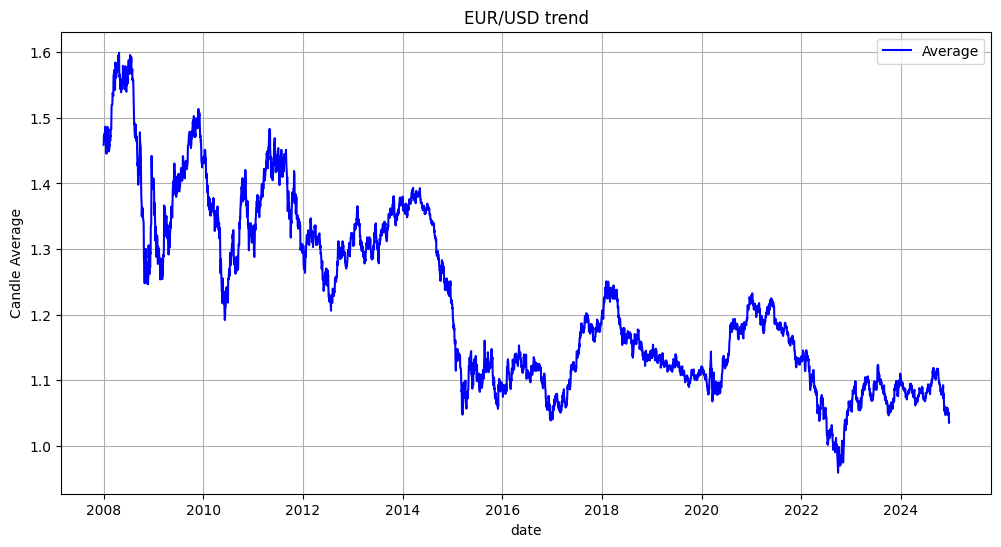

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
data['Day'] = data['Date'].dt.date
daily_data = data.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Average'], label='Average', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Candle Average')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

In [20]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'MA20',
       'MACD', 'ATR_4', 'ATR_14', 'ATR_40', 'BB_upper', 'BB_lower', 'Stoch_K',
       'CCI_20', 'adx_14', 'Candle_Range', 'Candle_Body', 'Close_Lag_1',
       'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5',
       'Rolling_Mean_10', 'Rolling_Std_20', 'Rolling_Max_20', 'Rolling_Min_20',
       'Hour_of_Day', 'Day_of_Week', 'Average', 'Average_Lag_1',
       'Average_Lag_2', 'Average_Lag_3', 'Average_Lag_4', 'Average_Lag_5'],
      dtype='object')

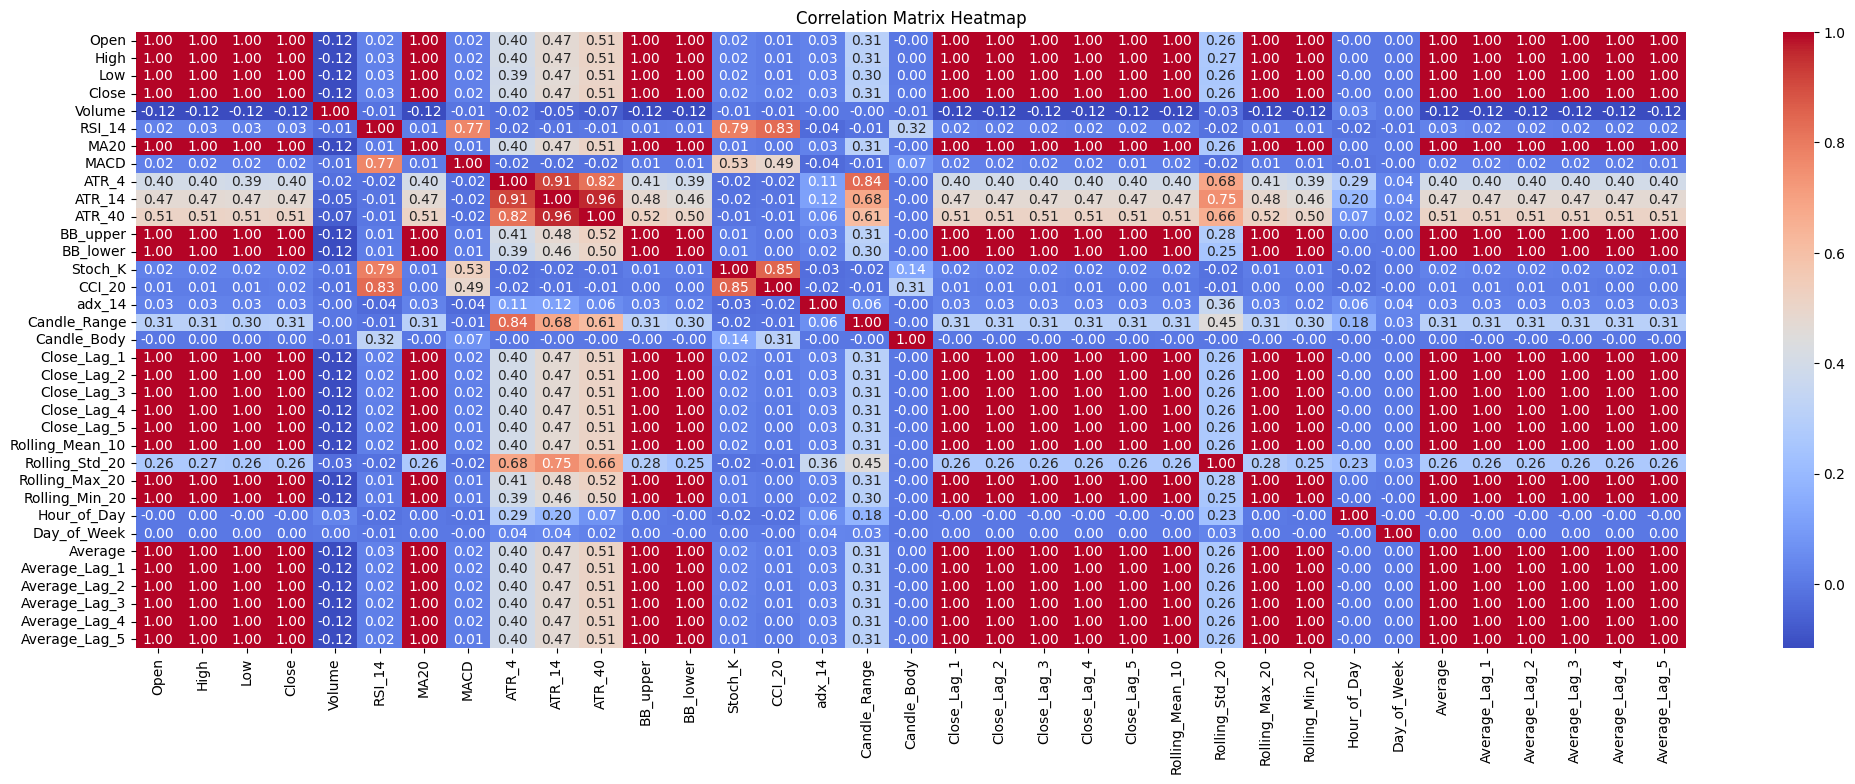

In [6]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'MA20',
       'MACD', 'ATR_4', 'ATR_14', 'ATR_40', 'BB_upper', 'BB_lower', 'Stoch_K',
       'CCI_20', 'adx_14', 'Candle_Range', 'Candle_Body', 'Close_Lag_1',
       'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5',
       'Rolling_Mean_10', 'Rolling_Std_20', 'Rolling_Max_20', 'Rolling_Min_20',
       'Hour_of_Day', 'Day_of_Week', 'Average', 'Average_Lag_1',
       'Average_Lag_2', 'Average_Lag_3', 'Average_Lag_4', 'Average_Lag_5']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [5]:
input_features = ['Close_Lag_1','Average_Lag_1','ATR_40','BB_upper','Rolling_Std_20','Hour_of_Day','Day_of_Week']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Average']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [6]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 90
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [7]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169432
تعداد نمونه‌های Validation: 21179
تعداد نمونه‌های Test: 21180


In [26]:
data.shape

(211881, 36)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, seq_length, units)
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),  # (units, 1)
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),  # (seq_length, 1)
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='attention_value',
                                 shape=(1, 1),  # فقط یه اسکالر برای جمع وزن‌دار
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, seq_length, units)
        # محاسبه امتیاز Attention
        e = tf.tanh(tf.tensordot(inputs, self.W, axes=[-1, 0]) + self.b)  # (batch_size, seq_length, 1)
        # نرمال‌سازی امتیازها
        e = tf.tensordot(e, self.V, axes=[-1, 0])  # (batch_size, seq_length, 1)
        alpha = tf.nn.softmax(e, axis=1)  # (batch_size, seq_length, 1)
        # محاسبه خروجی Attention
        context = inputs * alpha  # (batch_size, seq_length, units)
        context = tf.reduce_sum(context, axis=1)  # (batch_size, units)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])



seq_length = 90 

# تعریف مدل
model = Sequential([
    # لایه اول LSTM
    LSTM(200, return_sequences=True, input_shape=(seq_length, len(input_features))),
    Dropout(0.3),
    BatchNormalization(),

    # لایه دوم LSTM
    LSTM(150, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    # لایه سوم LSTM
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    # لایه چهارم LSTM
    LSTM(50, return_sequences=True),
    Dropout(0.3),

    # اضافه کردن لایه Attention
    AttentionLayer(),

    # لایه‌های Dense
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)  # خروجی
])


def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 200)             │         166,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 200)             │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 150)             │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 150)             │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 90, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 50)                  │             141 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 513,392 (1.96 MB)

 Trainable params: 512,492 (1.96 MB)

 Non-trainable params: 900 (3.52 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# آموزش مدل
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
4809/5295 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0030 - mae: 0.0339

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_average = scalers_outputs['Average'].inverse_transform(predictions[:, 0].reshape(-1, 1))


y_test_average = scalers_outputs['Average'].inverse_transform(y_test[:, 0].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_average, predictions_average, "Average")



# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.plot(y_test_average, label='real', color='blue')
plt.plot(predictions_average, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()



plt.tight_layout()
plt.show()